In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import style 
style.use('dark_background')

In [2]:
plt.rcParams["figure.figsize"] = (25,13)

# Preprocessing and creating target variable 

In [3]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1', parse_dates=['creation_time','last_session_creation_time'])
print(users.shape)
users.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [4]:
users.isna().sum()/len(users)*100

object_id                      0.000
creation_time                  0.000
name                           0.000
email                          0.000
creation_source                0.000
last_session_creation_time    26.475
opted_in_to_mailing_list       0.000
enabled_for_marketing_drip     0.000
org_id                         0.000
invited_by_user_id            46.525
dtype: float64

In [5]:
users['object_id'].nunique()

12000

12000 unique users/rows. 

In [6]:
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
print(engagement.shape)
engagement.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
engagement.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [8]:
engagement['user_id'].nunique()

8823

A little less than 9000 unique users, some in our other dataframe won't be represented.

Target: Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .

In [9]:
#function that gets a rolling count so we can find the 3 logins in 7 days. 
def get_rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

engagement['visits_7_days'] = engagement.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D')

In [10]:
#Convert the 3+ visits into boolean.  
adopted = []
for i in engagement['visits_7_days']:
    if i > 2:
        adopted.append(1)
    else: adopted.append(0)
        
engagement['adopted'] = adopted
engagement.head()

,time_stamp,user_id,visited,visits_7_days,adopted
0,2014-04-22 03:53:30,1,1,1.0,0
1,2013-11-15 03:45:04,2,1,1.0,0
2,2013-11-29 03:45:04,2,1,1.0,0
3,2013-12-09 03:45:04,2,1,1.0,0
4,2013-12-25 03:45:04,2,1,1.0,0


In [11]:
#grouping all of the timestamps by user id. 
neweng = engagement.groupby('user_id').aggregate(np.sum)
neweng.head()

,visited,visits_7_days,adopted
user_id,,,
1,1,1.0,0
2,14,22.0,2
3,1,1.0,0
4,1,1.0,0
5,1,1.0,0


In [12]:
#once again converting to boolean. 
adoptconv = []
for i in neweng['adopted']:
    if i > 0:
        adoptconv.append(1)
    else:
        adoptconv.append(0)
neweng['adopted'] = adoptconv
neweng.head()

,visited,visits_7_days,adopted
user_id,,,
1,1,1.0,0
2,14,22.0,1
3,1,1.0,0
4,1,1.0,0
5,1,1.0,0


In [13]:
neweng['adopted'].value_counts(normalize=True)

0    0.818429
1    0.181571
Name: adopted, dtype: float64

The dataset is highly imbalanced. 

In [14]:
neweng.shape

(8823, 3)

We have the same number of unique users as we did when we first started on the engagement dataframe so we're on the right track. 

In [15]:
#changing the name of the object id column so we can merge dataframes. 
users.rename(columns={'object_id':'user_id'}, inplace=True)
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [18]:
#reset index so we can match columns
neweng = neweng.reset_index()


In [19]:
#merging dataframes and only bringing over the adopted column
df = pd.merge(users, neweng[['user_id','adopted']],on='user_id', how='outer')

In [20]:
#checking unique users
print(df.shape)
df['user_id'].nunique()

(12000, 11)


12000

In [22]:
df.fillna(0, inplace=True)
df.isna().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted                       0
dtype: int64

# EDA

In [23]:
#making a copy for eda and adding a counter for groupbys 
eda = df.copy()
eda['counter'] = 1
eda.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,counter
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0,0.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0,0.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0,0.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0,0.0,1


In [25]:
#total number of adoptions calculation for proportions
totadopt = eda['adopted'].sum()
totadopt

1602.0

In [26]:
#grouping by creation source first 
source  = eda.groupby('creation_source').sum()
source = source[['counter','opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'adopted']]
source['%_of_total_adoptions'] = source['adopted']/totadopt*100
source

,counter,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,%_of_total_adoptions
creation_source,,,,,
GUEST_INVITE,2163,541,319,360.0,22.471910
ORG_INVITE,4254,1078,644,553.0,34.519351
PERSONAL_PROJECTS,2111,512,303,164.0,10.237203
SIGNUP,2087,525,319,293.0,18.289638
SIGNUP_GOOGLE_AUTH,1385,338,207,232.0,14.481898


In [27]:
org = eda.groupby('org_id').sum()
org = org[['counter', 'adopted', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']]
org['adopt_%'] = org['adopted']/org['counter']*100
org.sort_values(['adopt_%'], ascending=False, inplace=True)
org.head(20)

,counter,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip,adopt_%
org_id,,,,,
387,12,7.0,4,3,58.333333
235,13,6.0,8,4,46.153846
270,14,6.0,3,2,42.857143
399,13,5.0,4,2,38.461538
392,16,6.0,9,5,37.500000
415,16,6.0,2,0,37.500000
400,8,3.0,3,2,37.500000
117,22,8.0,8,3,36.363636
345,14,5.0,2,3,35.714286


In [28]:
time = eda.set_index('creation_time')
daily = time.groupby(pd.Grouper(freq='D')).agg(np.sum)
daily = daily[['counter', 'adopted', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']]
daily.sort_values('counter', ascending=False, inplace=True)


In [29]:
daily.sort_values('adopted', ascending=False, inplace=True)
daily.head(20)

,counter,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip
creation_time,,,,
2013-01-14,26,9.0,6,5
2013-10-29,16,9.0,3,4
2014-01-23,23,8.0,6,5
2013-03-14,31,8.0,7,3
2012-11-23,25,7.0,7,4
2013-08-05,16,7.0,2,2
2014-01-01,21,7.0,3,6
2013-09-28,19,6.0,5,1
2013-02-23,14,6.0,4,2


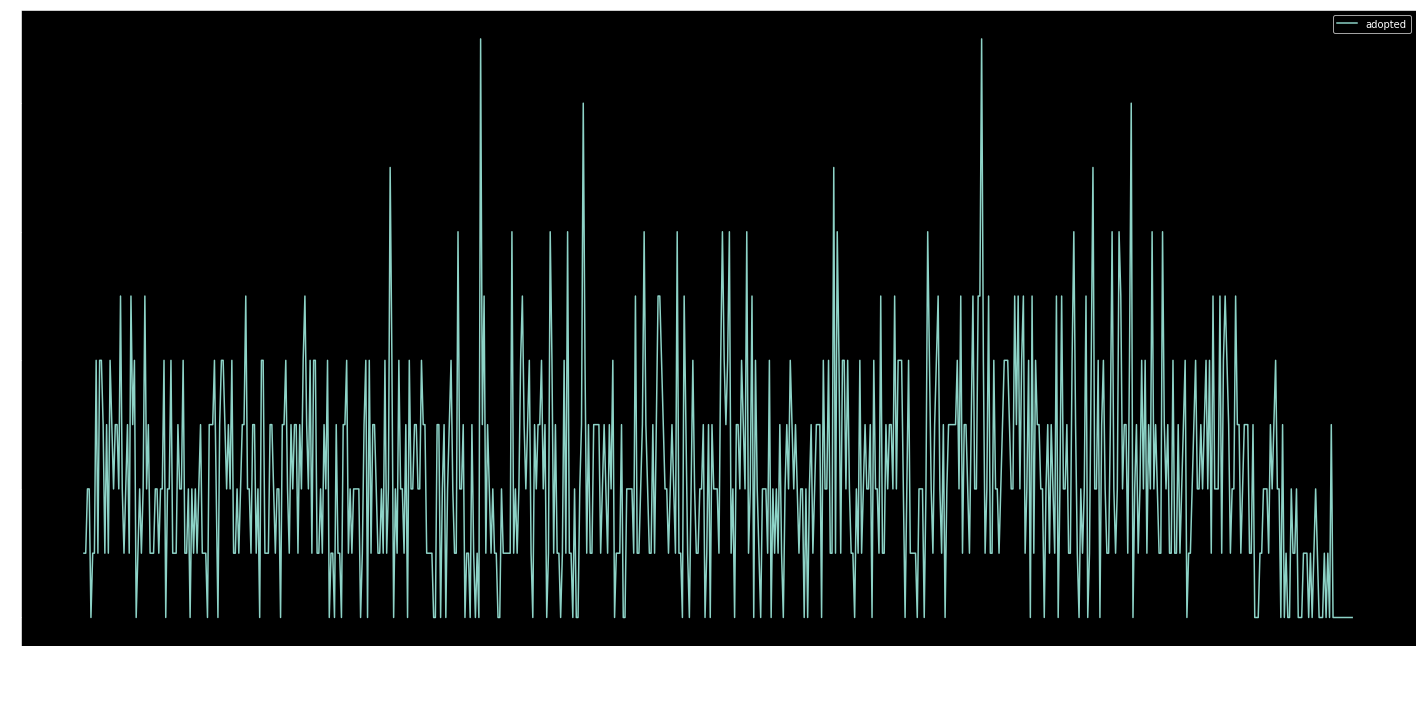

In [30]:
daily.plot(y='adopted')
plt.show()

In [32]:
monthly = time.groupby(pd.Grouper(freq='M')).agg(np.sum)
monthly = monthly[['counter', 'adopted', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']]
monthly.sort_values('counter', ascending=False, inplace=True)
monthly

,counter,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip
creation_time,,,,
2014-05-31,976,13.0,253,146
2014-04-30,730,40.0,183,115
2014-03-31,712,88.0,182,112
2014-01-31,582,90.0,145,91
2013-11-30,530,86.0,133,76
2014-02-28,527,63.0,118,92
2013-10-31,523,93.0,115,67
2013-12-31,518,69.0,117,70
2013-09-30,492,71.0,116,75


In [33]:
monthly.sort_values('adopted', ascending=False, inplace=True)
daily.head(20)

,counter,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip
creation_time,,,,
2013-01-14,26,9.0,6,5
2013-10-29,16,9.0,3,4
2014-01-23,23,8.0,6,5
2013-03-14,31,8.0,7,3
2012-11-23,25,7.0,7,4
2013-08-05,16,7.0,2,2
2014-01-01,21,7.0,3,6
2013-09-28,19,6.0,5,1
2013-02-23,14,6.0,4,2


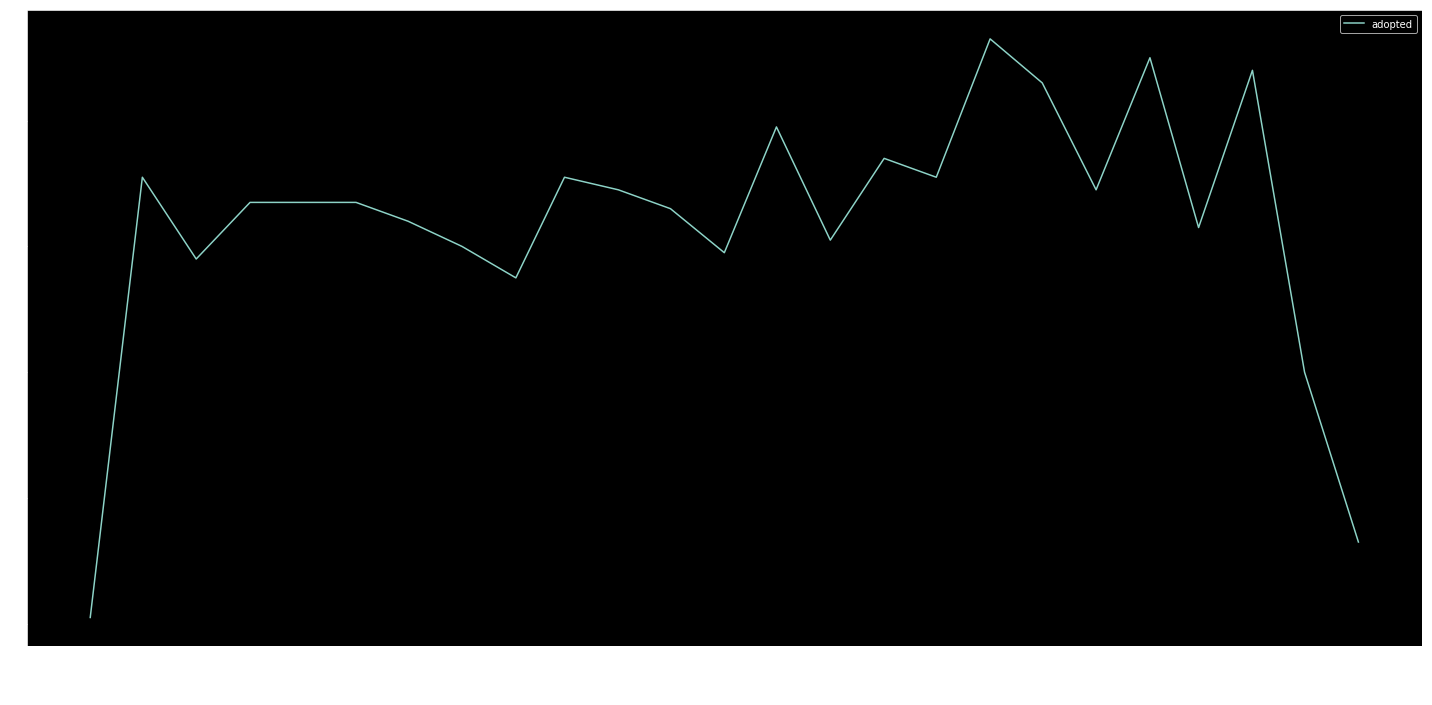

In [34]:
monthly.plot(y='adopted')
plt.show()

In [36]:
monthly.sort_index(inplace=True)
monthly.head()


,counter,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip
creation_time,,,,
2012-05-31,16,1.0,6,3
2012-06-30,401,71.0,96,55
2012-07-31,387,58.0,103,76
2012-08-31,365,67.0,91,45
2012-09-30,409,67.0,100,57


In [37]:
monthly.tail()

,counter,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip
creation_time,,,,
2014-01-31,582,90.0,145,91
2014-02-28,527,63.0,118,92
2014-03-31,712,88.0,182,112
2014-04-30,730,40.0,183,115
2014-05-31,976,13.0,253,146


# Machine Learning 

Need to encode our categorical variables. 

In [40]:
from sklearn.preprocessing import OneHotEncoder
def onehotness(df, cols):
    onehotdf = df[cols]
    hot = OneHotEncoder(sparse=False)
    encoded = hot.fit_transform(onehotdf)
    encdf = pd.DataFrame(encoded, columns=hot.get_feature_names())
    df = pd.concat([df.reset_index(), encdf.reset_index()], axis=1).drop(columns=cols, axis=1)
    return df

In [41]:
onehotlist = ['creation_source','invited_by_user_id', 'org_id']
mldf = onehotness(df.set_index('user_id'), onehotlist)
mldf.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,index,x0_GUEST_INVITE,...,x2_407,x2_408,x2_409,x2_410,x2_411,x2_412,x2_413,x2_414,x2_415,x2_416
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1398138810,1,0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1396237504,0,0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1363734892,0,0,0.0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1369210168,0,0,0.0,3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1358849660,0,0,0.0,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#drop the string and datetime columns 
mldf.drop(columns=['index', 'creation_time', 'name', 'email', 'last_session_creation_time'], inplace=True)
mldf.set_index('user_id', inplace=True)
mldf.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,x0_GUEST_INVITE,x0_ORG_INVITE,x0_PERSONAL_PROJECTS,x0_SIGNUP,x0_SIGNUP_GOOGLE_AUTH,x1_0.0,x1_3.0,...,x2_407,x2_408,x2_409,x2_410,x2_411,x2_412,x2_413,x2_414,x2_415,x2_416
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we need to upsample our data. 

In [44]:
#majority class and minority class dataframes. 
df_majority = mldf[mldf['adopted'] == 0]
df_minority = mldf[mldf['adopted'] == 1]

In [62]:
len(df_majority)

10398

In [45]:
#resample the minority class to get it 
from sklearn.utils import resample
df_min_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=10398,    
                                 random_state=7) 

In [46]:
df_upsampled = pd.concat([df_majority, df_min_upsampled])

In [47]:
df_upsampled['adopted'].value_counts()

1.0    10398
0.0    10398
Name: adopted, dtype: int64

Now we're evened out. Going to try out gradient boosting and random forest. 

In [52]:
import lightgbm as lgb 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [53]:
X = df_upsampled.drop(columns=['adopted']) 
y = df_upsampled['adopted']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=4) 

In [54]:
gb = lgb.LGBMClassifier()
gb_results = cross_val_score(gb, X_train, y_train, cv=5, scoring='f1')
print(f'The scores of our Gradient Boosting cross validation were {gb_results}')
print(f'The mean of our Gradient Boosting cross validation is {gb_results.mean()}')

The scores of our Gradient Boosting cross validation were [0.61783635 0.61557478 0.62776413 0.60976359 0.61743717]
The mean of our Gradient Boosting cross validation is 0.6176752029656185


61% isn't great. Let's try random forest. 

In [57]:
rf = RandomForestClassifier(n_estimators=10)
rf_results = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
print(f'The scores of our Random Forest cross validation were {rf_results}')
print(f'The mean of our Random Forest cross validation is {rf_results.mean()}')

The scores of our Random Forest cross validation were [0.86083956 0.88208357 0.8743662  0.88246956 0.86611945]
The mean of our Random Forest cross validation is 0.8731756665170382


Boom, random forest is on it. Let's go with that. 

In [59]:
rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.87
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      2105
         1.0       0.82      0.94      0.88      2055

   micro avg       0.87      0.87      0.87      4160
   macro avg       0.87      0.87      0.87      4160
weighted avg       0.88      0.87      0.87      4160



This is pretty good scoring. Let's see what it finds important. 

In [61]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances.head(20)

,index,importance
0,opted_in_to_mailing_list,0.056084
1,enabled_for_marketing_drip,0.037944
2,x0_PERSONAL_PROJECTS,0.010080
3,x2_0,0.007773
4,x0_SIGNUP_GOOGLE_AUTH,0.007465
5,x2_1,0.005107
6,x0_GUEST_INVITE,0.005049
7,x1_0.0,0.004736
8,x0_ORG_INVITE,0.004501
9,x0_SIGNUP,0.003578


By far, the most important features were if the user opted into the mailing list and were part of our marketing drip. The creation source of Personal Projects was a distant 3rd. Sounds like keeping our product top of mind via email reminders is very important. 